# Transfer Learning with TensorFlow: Fine-Tuning

## 1. Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.

In [292]:
def pred_and_plot(model, imgs, class_names):
  idx = np.random.randint(len(imgs))

  img = imgs[idx]

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))[0]
  print(pred)

  # Get the predicted class
  if len(pred)==1: 
    pred_class = class_names[round(pred[0])]
  else:
    pred_class = class_names[int(tf.argmax(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

## 2. Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using `tf.keras.applications.EfficientNetB0` as the base model. Use the `ModelCheckpoint` callback to save the weights to file.

### Prep Models

In [293]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-02-23 07:50:15--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.5’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-23 07:50:15 (88.5 MB/s) - ‘helper_functions.py.5’ saved [10246/10246]



In [294]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip 

unzip_data("10_food_classes_10_percent.zip")

--2023-02-23 07:50:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.128, 108.177.13.128, 172.217.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.5’

10_food_classes_10_ 100%[===================>] 160.74M  49.5MB/s    in 3.2s    

2023-02-23 07:50:19 (49.5 MB/s) - ‘10_food_classes_10_percent.zip.5’ saved [168546183/168546183]



In [295]:
# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [296]:
# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [297]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [298]:
# Check the training data datatype
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [299]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [300]:
# See an example batch of data
for images, labels in train_data_10_percent.take(0):
  print(images, labels)

In [301]:

# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20230223-075023
Epoch 1/5
24/24 [==============================] - 12s 186ms/step - loss: 1.8298 - accuracy: 0.4547 - val_loss: 1.2334 - val_accuracy: 0.7516
Epoch 2/5
24/24 [==============================] - 3s 118ms/step - loss: 1.0684 - accuracy: 0.7533 - val_loss: 0.8214 - val_accuracy: 0.8372
Epoch 3/5
24/24 [==============================] - 3s 119ms/step - loss: 0.7711 - accuracy: 0.8280 - val_loss: 0.6814 - val_accuracy: 0.8405
Epoch 4/5
24/24 [==============================] - 3s 118ms/step - loss: 0.6267 - accuracy: 0.8587 - val_loss: 0.5737 - val_accuracy: 0.8553
Epoch 5/5
24/24 [==============================] - 4s 172ms/step - loss: 0.5325 - accuracy: 0.8827 - val_loss: 0.5191 - val_accuracy: 0.8618


In [302]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_30 (Rescaling)       (None, None, None,   0           ['input_16[0][0]']               
                                3)                                                                
                                                                                                  
 normalization_15 (Normalizatio  (None, None, None,   7          ['rescaling_30[0][0]']           
 n)                             3)                                                   

In [303]:
# Check summary of model constructed with Functional API
model_0.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


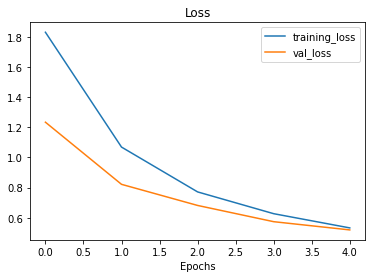

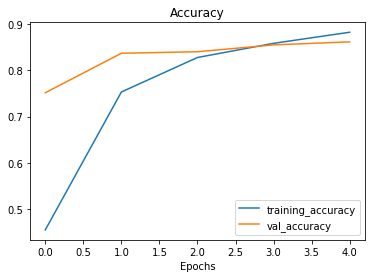

In [304]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

In [305]:
# Define input tensor shape (same number of dimensions as the output of efficientnetb0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)


In [306]:
# ^ similar to...

# This is the same as GlobalAveragePooling2D()
tf.reduce_mean(input_tensor, axis=[1, 2]) # average across the middle axes

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [307]:
# Download and unzip data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")

# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/"

--2023-02-23 07:50:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.218.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip.5’

10_food_classes_1_p 100%[===================>] 127.42M   301MB/s    in 0.4s    

2023-02-23 07:50:51 (301 MB/s) - ‘10_food_classes_1_percent.zip.5’ saved [133612354/133612354]



In [308]:
# Walk through 1 percent data directory and list number of files
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [309]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           batch_size=32, # default
                                                                           image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [310]:
[(train, test) for train, test in zip(train_data_1_percent, test_data)]

[((<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
   array([[[[1.67142868e+01, 2.71428585e+00, 1.27551004e-01],
            [1.63571434e+01, 3.35714293e+00, 0.00000000e+00],
            [1.75714302e+01, 4.57142878e+00, 0.00000000e+00],
            ...,
            [5.79285507e+01, 2.69285488e+01, 0.00000000e+00],
            [5.50714302e+01, 2.60714283e+01, 0.00000000e+00],
            [5.37142868e+01, 2.67142849e+01, 0.00000000e+00]],
   
           [[1.83316326e+01, 5.33163261e+00, 0.00000000e+00],
            [1.80714283e+01, 5.07142830e+00, 0.00000000e+00],
            [2.00000000e+01, 7.00000000e+00, 1.00000000e+00],
            ...,
            [5.98418388e+01, 2.88418388e+01, 9.28571463e-01],
            [5.89285698e+01, 2.89285717e+01, 9.28571463e-01],
            [5.59030571e+01, 2.89030590e+01, 0.00000000e+00]],
   
           [[1.72142868e+01, 4.21428585e+00, 0.00000000e+00],
            [1.82142868e+01, 5.21428585e+00, 0.00000000e+00],
            [1.92142868e+0

In [311]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

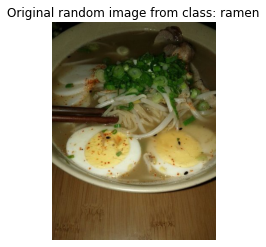

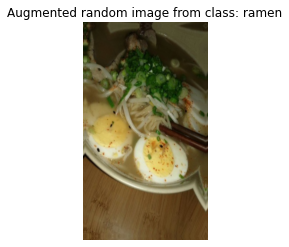

In [312]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [343]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                    epochs=5,
                    steps_per_epoch=len(train_data_1_percent),
                    validation_data=test_data,
                    validation_steps=int(0.25* len(test_data)), # validate for less steps
                    # Track model training logs
                    callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230223-080515
Epoch 1/5


3/3 [==============================] - 14s 3s/step - loss: 2.3768 - accuracy: 0.1143 - val_loss: 2.2490 - val_accuracy: 0.1694
Epoch 2/5
3/3 [==============================] - 2s 809ms/step - loss: 2.1541 - accuracy: 0.2286 - val_loss: 2.1018 - val_accuracy: 0.2516
Epoch 3/5
3/3 [==============================] - 3s 2s/step - loss: 1.9239 - accuracy: 0.4000 - val_loss: 1.9908 - val_accuracy: 0.3405
Epoch 4/5
3/3 [==============================] - 2s 823ms/step - loss: 1.7738 - accuracy: 0.5571 - val_loss: 1.8920 - val_accuracy: 0.4342
Epoch 5/5
3/3 [==============================] - 2s 940ms/step - loss: 1.5808 - accuracy: 0.6857 - val_loss: 1.7868 - val_accuracy: 0.4770


In [344]:

# Check out model summary
model_1.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

In [345]:
# Evaluate on the test data
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 5s 62ms/step - loss: 1.7830 - accuracy: 0.4956


[1.7829782962799072, 0.49559998512268066]

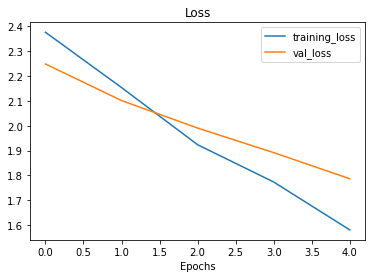

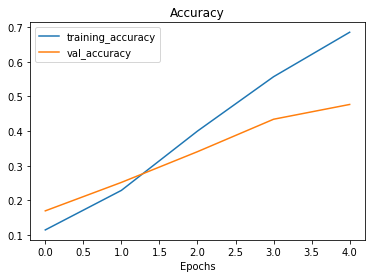

In [346]:
# How does the model go with a data augmentation layer with 1% of data
plot_loss_curves(history_1_percent)

In [350]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [351]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE)
# Note: the test data is the same as the previous experiment, we could
# skip creating this, but we'll leave this here to practice.
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [384]:
# Create a functional model with data augmentation
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal'),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomRotation(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNet                 
], name="data_augmentation")

# Setup the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input and output layers
inputs = layers.Input(shape=input_shape, name="input_layer") # create input layer
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, so batchnorm layers don't get updated: https://keras.io/guides/transfer_learning/#build-a-model 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# Compile
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.001), # use Adam optimizer with base learning rate
              metrics=["accuracy"])

In [385]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [386]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)), # do less steps per validation (quicker)
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"), 
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230223-082708
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 1.9715 - accuracy: 0.3560
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 18s 384ms/step - loss: 1.9715 - accuracy: 0.3560 - val_loss: 1.4014 - val_accuracy: 0.6990
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3217 - accuracy: 0.6640
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 7s 293ms/step - loss: 1.3217 - accuracy: 0.6640 - val_loss: 0.9383 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9917 - accuracy: 0.7680
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 333ms/step - loss: 0.9917 - accuracy: 0.7680 - val_loss: 0.7669 - val_accuracy: 0.8125
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.8281 - accuracy: 0.7840
Epoch 4

In [387]:
# Evaluate on the test data
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 5s 62ms/step - loss: 0.6237 - accuracy: 0.8396


[0.6237463355064392, 0.8396000266075134]

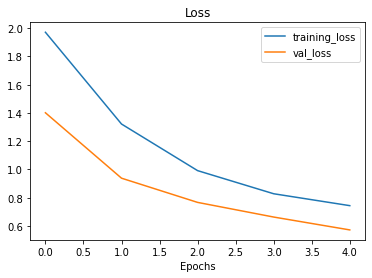

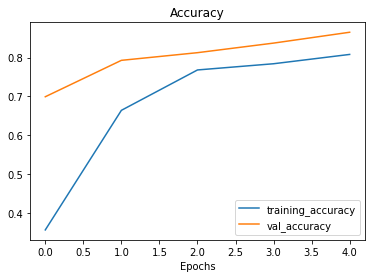

In [388]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [389]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 5s 62ms/step - loss: 0.6237 - accuracy: 0.8396


In [390]:
loaded_weights_model_results

[0.6237463355064392, 0.8396000266075134]

In [391]:
# If the results from our native model and the loaded weights are the same, this should output True
results_10_percent_data_aug == loaded_weights_model_results

True

In [392]:
import numpy as np
# Check to see if loaded model results are very close to native model results (should output True)
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [393]:
# Check the difference between the two results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))


[0. 0.]


In [394]:
model_2.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

In [400]:
# model_3 = tf.keras.models.clone_model(model_2)
# model_3.set_weights(model_2.get_weights())
model_3 = model_2

In [401]:
model_3.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

In [402]:
# Layers in loaded model
model_3.layers

In [403]:
for layer in model_3.layers:
  print(layer.trainable)

True
True
False
True
True


In [404]:
for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [405]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [406]:

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_21 False
1 rescaling_40 False
2 normalization_20 False
3 rescaling_41 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [407]:
print(len(model_3.trainable_variables))

12


In [408]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_3.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230223-082923
Epoch 5/10


24/24 [==============================] - 18s 359ms/step - loss: 0.7108 - accuracy: 0.7813 - val_loss: 0.5133 - val_accuracy: 0.8207
Epoch 6/10
24/24 [==============================] - 7s 271ms/step - loss: 0.3218 - accuracy: 0.9027 - val_loss: 0.4469 - val_accuracy: 0.8536
Epoch 7/10
24/24 [==============================] - 8s 325ms/step - loss: 0.2383 - accuracy: 0.9227 - val_loss: 0.4481 - val_accuracy: 0.8405
Epoch 8/10
24/24 [==============================] - 8s 316ms/step - loss: 0.1693 - accuracy: 0.9440 - val_loss: 0.4000 - val_accuracy: 0.8799
Epoch 9/10
24/24 [==============================] - 7s 275ms/step - loss: 0.1201 - accuracy: 0.9627 - val_loss: 0.5261 - val_accuracy: 0.8586
Epoch 10/10
24/24 [==============================] - 7s 265ms/step - loss: 0.1342 - accuracy: 0.9507 - val_loss: 0.4766 - val_accuracy: 0.8536


In [409]:
# Evaluate the model on the test data
results_fine_tune_10_percent = model_3.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.4988 - accuracy: 0.8524


In [410]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.35600000619888306, 0.6639999747276306, 0.7680000066757202, 0.7839999794960022, 0.8080000281333923, 0.781333327293396, 0.9026666879653931, 0.9226666688919067, 0.9440000057220459, 0.9626666903495789, 0.9506666660308838]


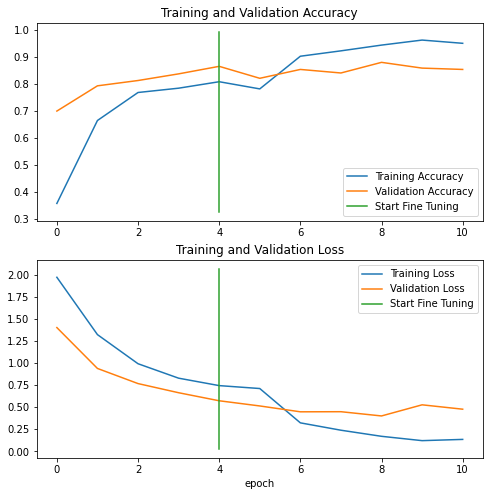

In [411]:
compare_historys(original_history=history_10_percent_data_aug, 
                 new_history=history_fine_10_percent_data_aug, 
                 initial_epochs=5)

In [412]:
# Download and unzip 10 classes of data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

# Setup data directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

--2023-02-23 08:30:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 142.251.107.128, 173.194.213.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip.6’

10_food_classes_all 100%[===================>] 495.13M   226MB/s    in 2.2s    

2023-02-23 08:30:38 (226 MB/s) - ‘10_food_classes_all_data.zip.6’ saved [519183241/519183241]



In [413]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE)

# Note: this is the same test dataset we've been using for the previous modelling experiments
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [414]:
# Evaluate model (this is the fine-tuned 10 percent of data version)
model_2.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.4988 - accuracy: 0.8524


[0.4987989366054535, 0.852400004863739]

In [ ]:
# # Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
# model_2.load_weights(checkpoint_path) # revert model back to saved weights

In [415]:
# After loading the weights, this should have gone down (no fine-tuning)
model_2.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.4988 - accuracy: 0.8524


[0.4987988770008087, 0.852400004863739]

In [416]:
# Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(lr=0.0001), # divide learning rate by 10 for fine-tuning
                metrics=["accuracy"])

In [417]:
# Continue to train and fine-tune the model to our data
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           callbacks=[create_tensorboard_callback("transfer_learning", "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20230223-083110
Epoch 5/10


235/235 [==============================] - 67s 239ms/step - loss: 0.5645 - accuracy: 0.8233 - val_loss: 0.3149 - val_accuracy: 0.9013
Epoch 6/10
235/235 [==============================] - 52s 222ms/step - loss: 0.3966 - accuracy: 0.8743 - val_loss: 0.2979 - val_accuracy: 0.9030
Epoch 7/10
235/235 [==============================] - 51s 217ms/step - loss: 0.3173 - accuracy: 0.8973 - val_loss: 0.2218 - val_accuracy: 0.9211
Epoch 8/10
235/235 [==============================] - 50s 210ms/step - loss: 0.2695 - accuracy: 0.9103 - val_loss: 0.3275 - val_accuracy: 0.8914
Epoch 9/10
235/235 [==============================] - 52s 219ms/step - loss: 0.2318 - accuracy: 0.9235 - val_loss: 0.2384 - val_accuracy: 0.9128
Epoch 10/10
235/235 [==============================] - 49s 207ms/step - loss: 0.1984 - accuracy: 0.9316 - val_loss: 0.2907 - val_accuracy: 0.9062


In [418]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 5s 61ms/step - loss: 0.3351 - accuracy: 0.9040


[0.33507367968559265, 0.9039999842643738]

5
11
[0.35600000619888306, 0.6639999747276306, 0.7680000066757202, 0.7839999794960022, 0.8080000281333923, 0.8233333230018616, 0.8742666840553284, 0.8973333239555359, 0.910266637802124, 0.923466682434082, 0.9315999746322632]


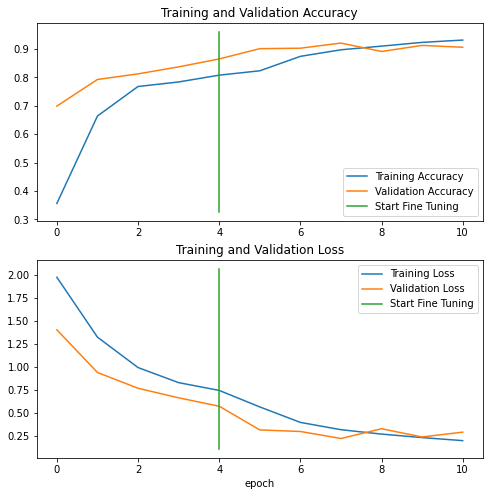

In [419]:
# How did fine-tuning go with more data?
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full,
                 initial_epochs=5)

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./transfer_learning \
#   --name "Transfer learning experiments" \
#   --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
#   --one_shot # exits the uploader when upload has finished

In [ ]:
# # View previous experiments
# !tensorboard dev list

### Main Model

In [420]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [421]:
# Setup checkpoint path
checkpoint_path = "main_model_checkpoint_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

In [422]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNet
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(x, training=False)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_main = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_main.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_main = model_main.fit(train_data_10_percent,
                                 epochs=10,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[
                                     create_tensorboard_callback("transfer_learning", "main_feature_extract"),
                                     checkpoint_callback
                                  ])

Shape after base_model: (None, None, None, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/main_feature_extract/20230223-083745
Epoch 1/10


24/24 [==============================] - ETA: 0s - loss: 2.0383 - accuracy: 0.3293
Epoch 1: saving model to main_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 17s 373ms/step - loss: 2.0383 - accuracy: 0.3293 - val_loss: 1.4408 - val_accuracy: 0.6957
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3216 - accuracy: 0.6893
Epoch 2: saving model to main_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 7s 271ms/step - loss: 1.3216 - accuracy: 0.6893 - val_loss: 0.9822 - val_accuracy: 0.7961
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.0093 - accuracy: 0.7627
Epoch 3: saving model to main_model_checkpoint_weights/checkpoint.ckpt
24/24 [==============================] - 6s 258ms/step - loss: 1.0093 - accuracy: 0.7627 - val_loss: 0.7935 - val_accuracy: 0.8174
Epoch 4/10
24/24 [==============================] - ETA: 0s - loss: 0.8394 - accuracy: 0.8040
Epoch 4: saving model to mai

In [423]:
len(test_data_10_percent)

79

In [424]:
len(test_data)

79

In [425]:
results_main = model_main.evaluate(test_data)
results_main

79/79 [==============================] - 5s 61ms/step - loss: 0.4977 - accuracy: 0.8612


[0.4976997673511505, 0.8611999750137329]

In [426]:
model_main.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-train

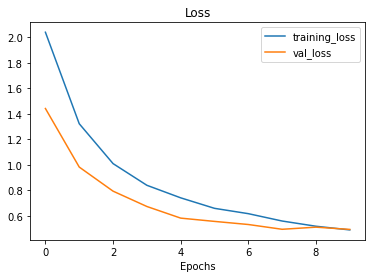

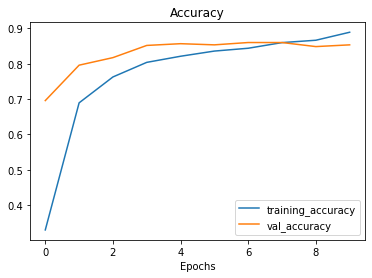

In [427]:
plot_loss_curves(history_main)

In [428]:
print(len(base_model.trainable_variables))

0


In [429]:

# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_22 False
1 rescaling_42 False
2 normalization_21 False
3 rescaling_43 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

## 3. Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [430]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_main.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [431]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_22 False
1 rescaling_42 False
2 normalization_21 False
3 rescaling_43 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze 

In [432]:
print(len(model_main.trainable_variables))

21


In [433]:
history_finetune_main_1 = model_main.fit(train_data_10_percent,
                                               epochs=20,
                                               validation_data=test_data,
                                               initial_epoch=history_main.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "finetune_main_1")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/finetune_main_1/20230223-084043
Epoch 10/20


24/24 [==============================] - 20s 352ms/step - loss: 0.6342 - accuracy: 0.7907 - val_loss: 0.5454 - val_accuracy: 0.8141
Epoch 11/20
24/24 [==============================] - 6s 242ms/step - loss: 0.2844 - accuracy: 0.9053 - val_loss: 0.4580 - val_accuracy: 0.8487
Epoch 12/20
24/24 [==============================] - 6s 254ms/step - loss: 0.1533 - accuracy: 0.9560 - val_loss: 0.3997 - val_accuracy: 0.8684
Epoch 13/20
24/24 [==============================] - 7s 307ms/step - loss: 0.0964 - accuracy: 0.9600 - val_loss: 0.5269 - val_accuracy: 0.8586
Epoch 14/20
24/24 [==============================] - 6s 244ms/step - loss: 0.1183 - accuracy: 0.9653 - val_loss: 0.4451 - val_accuracy: 0.8701
Epoch 15/20
24/24 [==============================] - 8s 328ms/step - loss: 0.0641 - accuracy: 0.9760 - val_loss: 0.6119 - val_accuracy: 0.8289
Epoch 16/20
24/24 [==============================] - 6s 243ms/step - loss: 0.0373 - accuracy: 0.9893 - val_loss: 0.4843 - val_accuracy: 0.8783
Epoch 17/2

In [434]:
results_finetune_main_1 = model_main.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.5684 - accuracy: 0.8544


In [435]:
def compare_historys_2(*historys, epochs_per=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    total_acc = historys[0].history["accuracy"]
    total_loss = historys[0].history["loss"]

    total_val_acc = historys[0].history["val_accuracy"]
    total_val_loss = historys[0].history["val_loss"]



    for history in historys[1:]:
      # Combine original history with new history
      total_acc = total_acc + history.history["accuracy"]
      total_loss = total_loss + history.history["loss"]

      total_val_acc = total_val_acc + history.history["val_accuracy"]
      total_val_loss = total_val_loss + history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')

    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')

    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

## 4. Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

In [436]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_main.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [437]:
history_finetune_main_2 = model_main.fit(train_data_10_percent,
                                               epochs=30,
                                               validation_data=test_data,
                                               initial_epoch=history_finetune_main_1.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "finetune_main_2")]) # name experiment appropriately

Saving TensorBoard log files to: transfer_learning/finetune_main_2/20230223-084242
Epoch 20/30


24/24 [==============================] - 21s 403ms/step - loss: 0.0898 - accuracy: 0.9773 - val_loss: 0.5424 - val_accuracy: 0.8553
Epoch 21/30
24/24 [==============================] - 7s 308ms/step - loss: 0.0683 - accuracy: 0.9720 - val_loss: 0.5822 - val_accuracy: 0.8438
Epoch 22/30
24/24 [==============================] - 7s 282ms/step - loss: 0.0735 - accuracy: 0.9720 - val_loss: 0.6235 - val_accuracy: 0.8618
Epoch 23/30
24/24 [==============================] - 7s 265ms/step - loss: 0.0469 - accuracy: 0.9853 - val_loss: 0.5756 - val_accuracy: 0.8684
Epoch 24/30
24/24 [==============================] - 7s 270ms/step - loss: 0.0342 - accuracy: 0.9893 - val_loss: 0.5841 - val_accuracy: 0.8635
Epoch 25/30
24/24 [==============================] - 7s 271ms/step - loss: 0.0822 - accuracy: 0.9787 - val_loss: 0.5927 - val_accuracy: 0.8635
Epoch 26/30
24/24 [==============================] - 7s 264ms/step - loss: 0.0325 - accuracy: 0.9880 - val_loss: 0.6266 - val_accuracy: 0.8536
Epoch 27/3

In [438]:
results_finetune_main_2 = model_main.evaluate(test_data)

79/79 [==============================] - 5s 61ms/step - loss: 0.7084 - accuracy: 0.8536


In [439]:
batches = [batch for batch in train_data_10_percent]

In [440]:
imgs, lbls = batches[0]

In [441]:
imgs

<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[1.31983261e+02, 9.99832611e+01, 6.19832611e+01],
         [1.31620529e+02, 9.96205368e+01, 6.15703125e+01],
         [1.30332596e+02, 9.83325882e+01, 5.94051323e+01],
         ...,
         [8.60078125e+01, 6.37220993e+01, 3.10546894e+01],
         [1.02529022e+02, 7.92555847e+01, 4.86004486e+01],
         [1.04805809e+02, 8.31149597e+01, 5.50535736e+01]],

        [[1.21924103e+02, 8.99241028e+01, 5.02566948e+01],
         [1.18416290e+02, 8.64162903e+01, 4.72712021e+01],
         [1.17314728e+02, 8.53147278e+01, 4.44575882e+01],
         ...,
         [8.95111542e+01, 6.64966507e+01, 2.27544594e+01],
         [9.08660583e+01, 6.77946320e+01, 2.59352570e+01],
         [1.12661827e+02, 9.08772278e+01, 4.87767792e+01]],

        [[1.19351562e+02, 8.83515625e+01, 4.39229927e+01],
         [1.20353798e+02, 8.93537979e+01, 4.49252243e+01],
         [1.22967636e+02, 9.19676361e+01, 4.75390625e+01],
         ...,
         [

In [442]:
lbls

<tf.Tensor: shape=(32, 10), dtype=float32, numpy=
array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1.,

In [443]:
class_names = ['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon', 'hamburger',
 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi']

In [444]:
len(class_names)

10

1/1 [==============================] - 2s 2s/step
[0.03863205 0.0734788  0.5286752  0.00998481 0.01041155 0.03583873
 0.02754774 0.04007479 0.01973259 0.21562375]


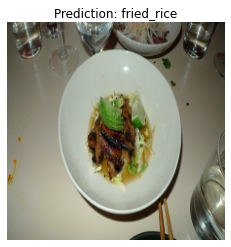

In [445]:
pred_and_plot(model_main, imgs/255., class_names)

32
[0.3293333351612091, 0.6893333196640015, 0.762666642665863, 0.8040000200271606, 0.8213333487510681, 0.8360000252723694, 0.843999981880188, 0.8600000143051147, 0.8666666746139526, 0.8893333077430725, 0.7906666398048401, 0.9053333401679993, 0.9559999704360962, 0.9599999785423279, 0.9653333425521851, 0.9760000109672546, 0.9893333315849304, 0.9679999947547913, 0.9919999837875366, 0.9893333315849304, 0.984000027179718, 0.9773333072662354, 0.972000002861023, 0.972000002861023, 0.9853333234786987, 0.9893333315849304, 0.9786666631698608, 0.9879999756813049, 0.9879999756813049, 0.9906666874885559, 0.9800000190734863, 0.9786666631698608]


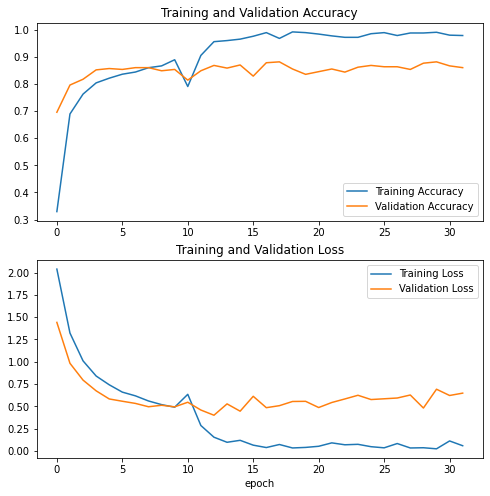

In [446]:
compare_historys_2(history_main, history_finetune_main_1, history_finetune_main_2)